# eBay Auction Price Prediction Model


This notebook demonstrates the use of machine learning models to predict the price of eBay auctions that resulted in a sale.

We will evaluate two models for price prediction:
1. **Random Forest Regressor** for regression task
2. **Linear Regression** for regression task

The dataset used is filtered to only include auctions that resulted in a sale.


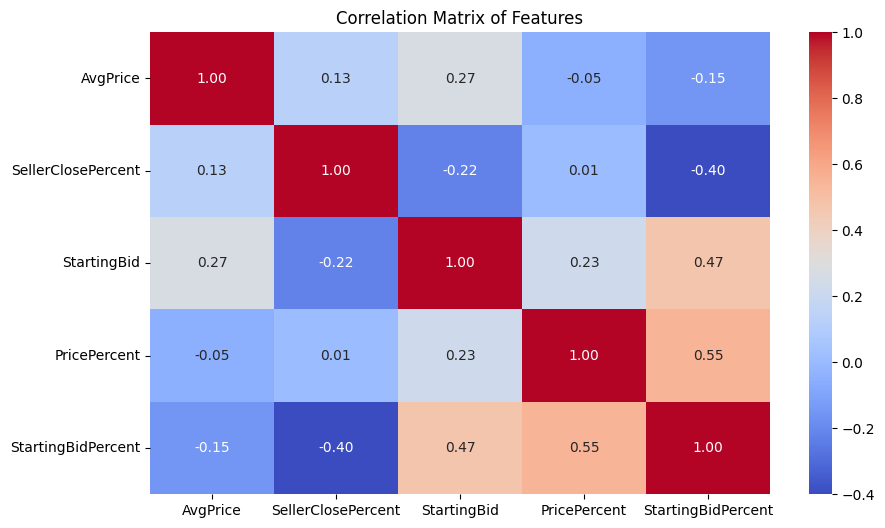

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the CSV files
file_path = 'raw.tar.gz'
extracted_path = '/mnt/data/raw_data/'

# Extracting files and loading data
import tarfile
import os
with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall(path=extracted_path)

raw_dir = os.path.join(extracted_path, 'raw')
training_subset = pd.read_csv(os.path.join(raw_dir, 'TrainingSubset.csv'))
test_subset = pd.read_csv(os.path.join(raw_dir, 'TestSubset.csv'))

# Filter only auctions that resulted in a sale
train_sub = training_subset[training_subset['QuantitySold'] == 1]  # Only sales
test_sub = test_subset[test_subset['QuantitySold'] == 1]

# Separate numeric and categorical columns
numeric_cols = train_sub.select_dtypes(include=[np.number]).columns
categorical_cols = train_sub.select_dtypes(exclude=[np.number]).columns

# Handle missing values for numeric columns (fill with median)
train_sub[numeric_cols] = train_sub[numeric_cols].fillna(train_sub[numeric_cols].median())
test_sub[numeric_cols] = test_sub[numeric_cols].fillna(test_sub[numeric_cols].median())

# Handle missing values for categorical columns (fill with mode)
train_sub[categorical_cols] = train_sub[categorical_cols].fillna(train_sub[categorical_cols].mode().iloc[0])
test_sub[categorical_cols] = test_sub[categorical_cols].fillna(test_sub[categorical_cols].mode().iloc[0])

# Check correlation matrix of features
features_sub = ['AvgPrice', 'SellerClosePercent', 'StartingBid', 'PricePercent', 'StartingBidPercent']
corr_matrix = train_sub[features_sub].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

# Feature Selection for Price prediction
X_train_sub = train_sub[features_sub]
y_train_sub = train_sub['Price']
X_test_sub = test_sub[features_sub]
y_test_sub = test_sub['Price']

# Scaling data
scaler = StandardScaler()
X_train_sub_scaled = scaler.fit_transform(X_train_sub)
X_test_sub_scaled = scaler.transform(X_test_sub)

# Train/Test Split (Optional: could be used for cross-validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_sub_scaled, y_train_sub, test_size=0.2, random_state=42)

# the correlation between StartingBid and StartingBidPercent (0.47) is moderate,
# so there doesn't seem to be a high risk of multicollinearity in this particular example.
# there is also some relationship between StartingBidPercent and PricePercent, meaning that as one of these variables increases, the other is also likely to increase to some extent.
# However, this is not a very strong relationship.
# if any pair of features had correlations greater than 0.9, it would be worth investigating further.


Linear Regression - MSE (CV): 1009.1824, RMSE (CV): 31.7676, R^2 (CV): 0.5158, Std (CV): 610.8970
Random Forest - MSE (CV): 13.0584, RMSE (CV): 3.6136, R^2 (CV): 0.9924


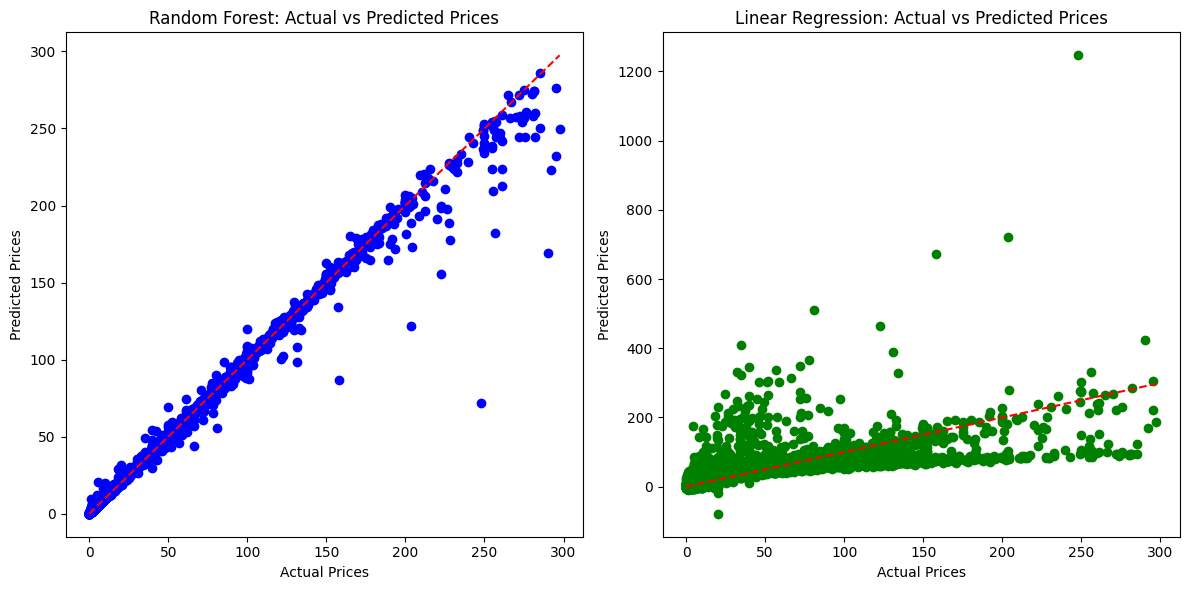

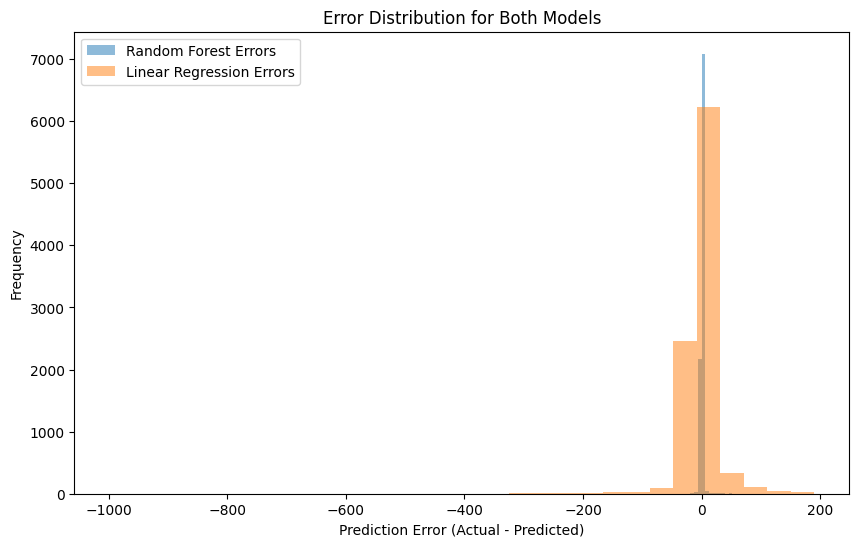

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

# Model 1: Linear Regression with Cross-Validation
lr_regressor = LinearRegression()

# Perform 5-fold cross-validation on the training data
cv_scores_lr = cross_val_score(lr_regressor, X_train_sub_scaled, y_train_sub, cv=5, scoring='neg_mean_squared_error')

# Compute the mean and standard deviation of the cross-validation scores
mse_lr_cv = -cv_scores_lr.mean()  # The result of cross_val_score for MSE is negative, so negate it
std_lr_cv = cv_scores_lr.std()

# Calculate RMSE and R^2 (for completeness)
rmse_lr_cv = np.sqrt(mse_lr_cv)
r2_lr_cv = 1 - (mse_lr_cv / np.var(y_train_sub))  # R^2 calculated manually

# Train Linear Regression model and make predictions
lr_regressor.fit(X_train_sub_scaled, y_train_sub)
y_pred_lr = lr_regressor.predict(X_test_sub_scaled)

# Calculate metrics for Linear Regression
mse_lr = mean_squared_error(y_test_sub, y_pred_lr)
mae_lr = mean_absolute_error(y_test_sub, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test_sub, y_pred_lr)

# Model 2: Random Forest Regressor with best parameters from previous GridSearchCV
rf_regressor = RandomForestRegressor(
    n_estimators=200,
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)

# Train Random Forest model with best parameters
rf_regressor.fit(X_train_sub_scaled, y_train_sub)

# Predictions using Random Forest
y_pred_rf = rf_regressor.predict(X_test_sub_scaled)

# Calculate metrics for Random Forest
mse_rf = mean_squared_error(y_test_sub, y_pred_rf)
mae_rf = mean_absolute_error(y_test_sub, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test_sub, y_pred_rf)

# Output the evaluation results
print(f"Linear Regression - MSE (CV): {mse_lr_cv:.4f}, RMSE (CV): {rmse_lr_cv:.4f}, R^2 (CV): {r2_lr_cv:.4f}, Std (CV): {std_lr_cv:.4f}")
print(f"Random Forest - MSE (CV): {mse_rf:.4f}, RMSE (CV): {rmse_rf:.4f}, R^2 (CV): {r2_rf:.4f}")

# Plotting Actual vs Predicted for both models
plt.figure(figsize=(12, 6))

# Random Forest Predictions vs Actual Prices
plt.subplot(1, 2, 1)
plt.scatter(y_test_sub, y_pred_rf, color='blue')
plt.plot([y_test_sub.min(), y_test_sub.max()], [y_test_sub.min(), y_test_sub.max()], color='red', linestyle='--')
plt.title("Random Forest: Actual vs Predicted Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")

# Linear Regression Predictions vs Actual Prices
plt.subplot(1, 2, 2)
plt.scatter(y_test_sub, y_pred_lr, color='green')
plt.plot([y_test_sub.min(), y_test_sub.max()], [y_test_sub.min(), y_test_sub.max()], color='red', linestyle='--')
plt.title("Linear Regression: Actual vs Predicted Prices")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")

# Display the plots
plt.tight_layout()
plt.show()

# Compare model performance (visualization of errors)
plt.figure(figsize=(10, 6))
plt.hist(y_test_sub - y_pred_rf, bins=30, alpha=0.5, label='Random Forest Errors')
plt.hist(y_test_sub - y_pred_lr, bins=30, alpha=0.5, label='Linear Regression Errors')
plt.legend()
plt.title('Error Distribution for Both Models')
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()
